In [5]:
import numpy as np
import itertools
import logging
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

from nf.flows import NSF_CL
from nf.models import NormalizingFlowModel

In [6]:
%config InlineBackend.figure_format = "retina"
sns.set()

  0%|          | 0/500 [00:00<?, ?it/s]

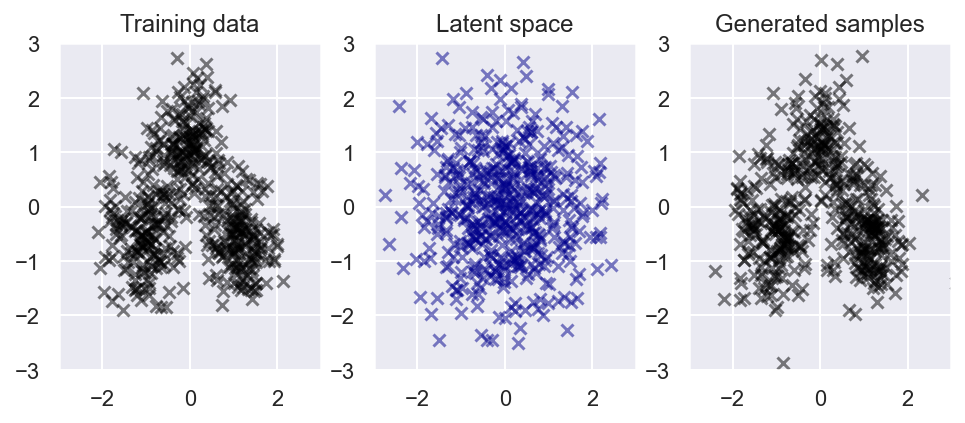

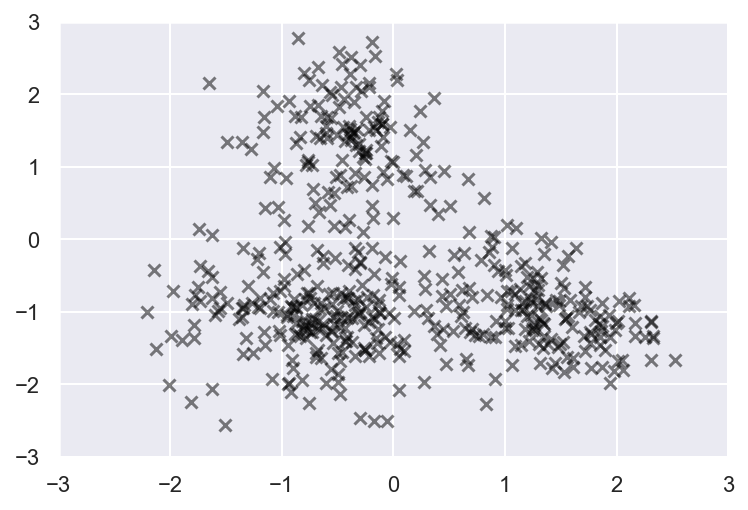

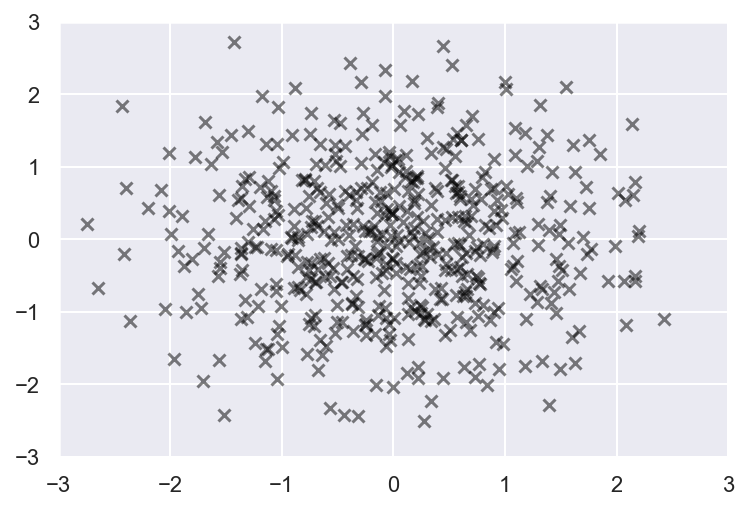

In [10]:
def gen_data(n=512):
    return np.r_[np.random.randn(n // 3, 2) + np.array([0, 6]),
                 np.random.randn(n // 3, 2) + np.array([2.5, 3]),
                 np.random.randn(n // 3, 2) + np.array([-2.5, 3])]


def gen_mixture_data(n=512):
    return np.r_[np.random.randn(n // 2, 2) + np.array([5, 3]),
                 np.random.randn(n // 2, 2) + np.array([-5, 3])]



def plot_data(x, **kwargs):
    plt.scatter(x[:,0], x[:,1], marker="x", **kwargs)
    plt.xlim((-3, 3))
    plt.ylim((-3, 3))


if __name__ == "__main__":
    
    n = 512
    flows = 2
    flow = NSF_CL
    iterations = 500
    use_mixture = False
    convolve = False
    actnorm = False

    # flow = eval(args.flow)
    flows = [flow(dim=2) for _ in range(flows)]
    if convolve:
        convs = [OneByOneConv(dim=2) for _ in range(flows)]
        flows = list(itertools.chain(*zip(convs, flows)))
    if actnorm:
        actnorms = [ActNorm(dim=2) for _ in range(flows)]
        flows = list(itertools.chain(*zip(actnorms, flows)))
    prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
    model = NormalizingFlowModel(prior, flows)

    optimizer = optim.Adam(model.parameters(), lr=0.005)
    if use_mixture:
        x = torch.Tensor(gen_mixture_data(n))
    else:
        x = torch.Tensor(gen_data(n))

    for i in range(x.shape[1]):
        x[:,i] = (x[:,i] - torch.mean(x[:,i])) / torch.std(x[:,i])
        
    hist_loss = np.zeros(iterations)
    
    with tqdm(total=iterations) as pbar:
        for i in range(iterations):
        
            optimizer.zero_grad()
            z, prior_logprob, log_det = model(x)
            logprob = prior_logprob + log_det
            loss = -torch.mean(prior_logprob + log_det)
            loss.backward()
            optimizer.step()
            
            hist_loss[i] = loss.item()
            if i != 0:
                pbar.set_postfix({'loss': np.mean(hist_loss[i-50:i])})
            pbar.update()

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 3, 1)
    plot_data(x, color="black", alpha=0.5)
    plt.title("Training data")
    plt.subplot(1, 3, 2)
    plot_data(z.data, color="darkblue", alpha=0.5)
    plt.title("Latent space")
    plt.subplot(1, 3, 3)
    samples = model.sample(500).data
    plot_data(samples, color="black", alpha=0.5)
    plt.title("Generated samples")
    plt.show()

    for f in flows:
        x = f(x)[0].data
        plot_data(x, color="black", alpha=0.5)
        plt.show()

